# Group 2 Optical Character Recognition Project Project - Group 2
## Summary
This project is to explore creating a character recognition system utilizing a convolutional neural network
## Completed By:
Aidan MacNichol – 30094369

Bailey Collison – 30133909

David Pozniak – 00324580

Yael Gonzalez - 30247278

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import save_image
from torchvision.transforms import InterpolationMode
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
from tqdm import tqdm

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import random

import re
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['TORCH_USE_CUDA_DSA'] = "1"
os.environ['TF_ENABLE_ONEDNN_OPTS'] = "0"

import warnings
warnings.filterwarnings(action='ignore')

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('CUDA available', torch.cuda.is_available())
print('CUDA version', torch.version.cuda)
print('cuDNN enabled', torch.backends.cudnn.enabled)
print('cuDNN version', torch.backends.cudnn.version())
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print('Device name:', torch.cuda.get_device_name(0))
print('Device:', device)

CUDA available True
CUDA version 12.4
cuDNN enabled True
cuDNN version 90100
PyTorch version: 2.6.0+cu124
Torchvision version: 0.21.0+cu124
Device name: NVIDIA GeForce RTX 2080 Ti
Device: cuda:0


In [2]:
# import torchvision.transforms.functional as F

# def random_skew(img):
#     shear_x = random.uniform(-15, 15)
#     shear_y = random.uniform(-15, 15)
#     return F.affine(img, angle=0, translate=(0, 0), scale=1.0, shear=(shear_x, shear_y))

# def random_resize(img):
#     aug_img_size_h = random.randint(28, 32)
#     aug_img_size_w = random.randint(28, 32)
#     img = F.resize(img, (aug_img_size_h + 1, aug_img_size_w + 1))
#     img = F.crop(img, top=random.randint(0, 1), left=random.randint(0, 1), height=aug_img_size_h, width=aug_img_size_w)
#     return img
    
# def random_color_jitter(img):
#     brightness = random.uniform(0.8, 1.2)
#     contrast = random.uniform(0.8, 1.2)
#     return transforms.functional.adjust_brightness(
#         transforms.functional.adjust_contrast(img, contrast), brightness
#     )

# def random_normalize(img):
#     mean = random.uniform(0.4, 0.6)
#     std = random.uniform(0.4, 0.6)
#     return transforms.functional.normalize(img, [mean], [std])

# augmentation_transform = transforms.Compose([
#     transforms.Pad(padding=5, fill=255),
#     transforms.Lambda(random_skew),
#     transforms.Lambda(random_resize),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomVerticalFlip(),
#     transforms.Lambda(random_color_jitter),
#     transforms.ToTensor(),
#     transforms.Lambda(random_normalize),
# ])


# dataset = ImageFolder(root="./data/training_data")
# output_dir = "./data/augmented_training_data"
# os.makedirs(output_dir, exist_ok=True)

# num_augmentations = 5

# for idx in range(len(dataset)):
#     image, label = dataset[idx]
#     class_dir = os.path.join(output_dir, dataset.classes[label])
#     os.makedirs(class_dir, exist_ok=True)
#     for aug_idx in range(num_augmentations):
#         augmented_image = augmentation_transform(image)
#         save_image(augmented_image, os.path.join(class_dir, f"image_{idx}_aug_{aug_idx}.png"))

In [3]:
# Function to compute dataset statistics (same as mnist example)
def get_dataset_stats(data_loader):
    mean = 0.
    std = 0.
    nb_samples = 0.
    for data in data_loader:
        images = data[0]
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        nb_samples += batch_samples
    mean /= nb_samples
    std /= nb_samples
    return mean, std
    
# Extract text from file names as well as labels
def read_text_files_with_labels(path):
    texts = []
    labels = []
    class_folders = sorted(os.listdir(path))
    label_map = {class_name: idx for idx, class_name in enumerate(class_folders)}
    for class_name in class_folders:
        class_path = os.path.join(path, class_name)
        if os.path.isdir(class_path):
            file_names = os.listdir(class_path)
            for file_name in file_names:
                file_path = os.path.join(class_path, file_name)
                if os.path.isfile(file_path):
                    file_name_no_ext, _ = os.path.splitext(file_name)
                    text = file_name_no_ext.replace('_', ' ')
                    texts.append(text)
                    labels.append(class_name) # label_map[class_name]
    return np.array(texts), np.array(labels)
    
# functions to show an image (also same as mnist example)
def imshow(img,stats):
    # when unnormalizing, I had to add extra channels for RGB
    img = img * stats[1].view(-1, 1, 1) + stats[0].view(-1, 1, 1)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

class EarlyStopper():
    def __init__(self, patience=3):
        self.best_val = np.inf
        self.current_val = np.inf
        self.patience = patience
        self.steps_since_last_best = 0
    def __call__(self, val) -> bool:
        self.current_val = val
        self._update_best()
        if self.steps_since_last_best == self.patience:
            return True
        else:
            return False
    def _update_best(self):
        if self.current_val < self.best_val:
            print(f"New best mse: {self.current_val:.4f}")
            self.best_val = self.current_val
            self.steps_since_last_best = 0
        else:
            self.steps_since_last_best += 1

def predict(model, dataloader, device, classes):
    model = model.to(device)
    model.eval() 
    predictions = []
    predict_loop = tqdm(dataloader, desc="Predicting", leave=False)
    with torch.no_grad(): 
        for data in predict_loop:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, dim=1)
            predictions.extend(preds.cpu().numpy())
            correct = (preds == labels).sum().item()
            accuracy = correct / len(labels)
            predict_loop.set_postfix({"Batch Accuracy": f"{accuracy:.2f}"})
    predictions = [classes[pred] for pred in predictions]
    return predictions

In [4]:
batch_size = 1024
image_resize = 28
num_workers = 16

# "./data/training_data"
# "./data/testing_data" 
# "./data/augmented_training_data"
# "./data/all_training_data"
train_folder = "./data/training_data"
test_folder = "./data/testing_data" 

nepochs = 100
best_loss = float('inf')
PATH = './best_char_model.pth'

# Extract text + lables
text_train, labels_train = read_text_files_with_labels(train_folder)
text_test, labels_test = read_text_files_with_labels(test_folder)

initial_transform = transforms.Compose([
            transforms.Resize((image_resize, image_resize), interpolation=InterpolationMode.BILINEAR),  # I was getting an error if I didn't resize
            transforms.Grayscale(num_output_channels=1),       
            transforms.ToTensor()])

train_dataset_initial = torchvision.datasets.ImageFolder(root=train_folder, transform=initial_transform)

train_loader_initial = torch.utils.data.DataLoader(train_dataset_initial, batch_size=batch_size, shuffle=True, num_workers=num_workers)

stats = get_dataset_stats(train_loader_initial)

transform = {
    "train": transforms.Compose([
            transforms.Resize((image_resize, image_resize), interpolation=InterpolationMode.BILINEAR),
            # transforms.RandomCrop(image_resize),
            # transforms.RandomHorizontalFlip(),
            # transforms.RandomVerticalFlip(),
            # transforms.ColorJitter(brightness=0.15, contrast=0.15),
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor(),
            transforms.Normalize((stats[0]), (stats[1]))]),
    "test": transforms.Compose([
            transforms.Resize((image_resize, image_resize)),
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor(),
            transforms.Normalize((stats[0]), (stats[1]))])
}

# Reload the dataset with the new transform
train_dataset = torchvision.datasets.ImageFolder(root=train_folder, transform=transform["train"])

train_set_size = int(0.8 * len(train_dataset))
val_set_size = len(train_dataset) - train_set_size

train_set, val_set = torch.utils.data.random_split(train_dataset, [train_set_size, val_set_size], generator=torch.Generator().manual_seed(0))

# Load test dataset with same transform
test_dataset = torchvision.datasets.ImageFolder(root=test_folder, transform=transform["test"])

# data loaders for training, validation, and test sets
trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
valloader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

# get classes from folder names
classes = train_dataset.classes
print("Classes:", classes)

Classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


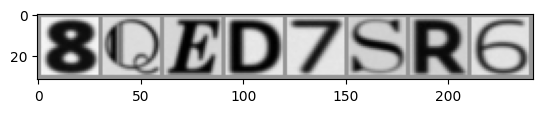

8     Q     E     D     7     S     R     6    


In [5]:
# get some random training images and print them
dataiter = iter(trainloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:8]), stats)
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(8)))

In [6]:
class Net(nn.Module):
    def __init__(self, num_classes):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(64*12*12, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        # Flatten the tensor into a 1D vector
        x = x.view(-1, 64*12*12)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

num_classes = len(train_dataset.classes)
print("Number of classes: ", num_classes)

net = Net(num_classes)
net.to(device)

Number of classes:  36


Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=36, bias=True)
)

In [7]:
criterion = nn.CrossEntropyLoss() # Loss function
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9) # Optimizer used for training
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)
early_stopper = EarlyStopper(patience=5)

In [8]:
for epoch in range(nepochs):
    # Training Loop
    train_loss = 0.0
    net.train()
    train_loop = tqdm(trainloader, desc=f"Epoch {epoch + 1}/{nepochs} [Training]", leave=False)
    for i, data in enumerate(train_loop):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_loop.set_postfix({"Train Loss": f"{loss.item():.3f}"})
    avg_train_loss = train_loss / len(trainloader)
    print(f'Epoch {epoch + 1}, Train Loss: {avg_train_loss:.3f},', end=' ')

    # Validation Loop
    net.eval()
    val_loss = 0.0
    val_loop = tqdm(valloader, desc=f"Epoch {epoch + 1}/{nepochs} [Validation]", leave=False)
    with torch.no_grad():
        for i, data in enumerate(val_loop):
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_loop.set_postfix({"Val Loss": f"{loss.item():.3f}"})
    avg_val_loss = val_loss / len(valloader)
    print(f'Val Loss: {avg_val_loss:.3f}')

    if early_stopper(val_loss):
        break
    if early_stopper.steps_since_last_best == 0:
        torch.save(net.state_dict(), PATH)
        
    scheduler.step()
    
print('Finished Training')

Epoch 1, Train Loss: 3.432, 

Val Loss: 2.976
New best mse: 14.8792


Epoch 2, Train Loss: 1.582, 

Val Loss: 0.731
New best mse: 3.6557


Epoch 3, Train Loss: 0.559, 

Val Loss: 0.588
New best mse: 2.9399


Epoch 4, Train Loss: 0.429, 

Val Loss: 0.337
New best mse: 1.6855


Epoch 5, Train Loss: 0.296, 

Val Loss: 0.308
New best mse: 1.5387


Epoch 6, Train Loss: 0.246, 

Val Loss: 0.245
New best mse: 1.2241


Epoch 7, Train Loss: 0.223, 

Val Loss: 0.248


Epoch 8, Train Loss: 0.204, 

Val Loss: 0.242
New best mse: 1.2101


Epoch 9, Train Loss: 0.193, 

Val Loss: 0.232
New best mse: 1.1578


Epoch 10, Train Loss: 0.176, 

Val Loss: 0.225
New best mse: 1.1258


Epoch 11, Train Loss: 0.165, 

Val Loss: 0.219
New best mse: 1.0934


Epoch 12, Train Loss: 0.172, 

Val Loss: 0.230


Epoch 13, Train Loss: 0.163, 

Val Loss: 0.221


Epoch 14, Train Loss: 0.159, 

Val Loss: 0.213
New best mse: 1.0674


Epoch 15, Train Loss: 0.137, 

Val Loss: 0.201
New best mse: 1.0064


Epoch 16, Train Loss: 0.139, 

Val Loss: 0.213


Epoch 17, Train Loss: 0.138, 

Val Loss: 0.210


Epoch 18, Train Loss: 0.124, 

Val Loss: 0.224


Epoch 19, Train Loss: 0.111, 

Val Loss: 0.221


Epoch 20, Train Loss: 0.109, 

Val Loss: 0.215
Finished Training


In [9]:
# Load the best model to be used in the test set
net = Net(num_classes)
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

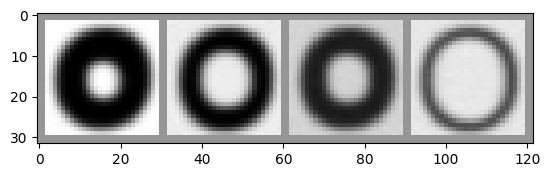

GroundTruth:  0     0     0     0    


In [10]:
dataiter = iter(testloader)
images, labels = next(dataiter)
# print images
imshow(torchvision.utils.make_grid(images[:4]), stats)
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))
outputs = net(images)

In [11]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  0     0     0     0    


In [12]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total} %')

Accuracy of the network on the 10000 test images: 97.61904761904762 %


In [13]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: 0     is 82.1 %
Accuracy for class: 1     is 100.0 %
Accuracy for class: 2     is 100.0 %
Accuracy for class: 3     is 100.0 %
Accuracy for class: 4     is 100.0 %
Accuracy for class: 5     is 96.4 %
Accuracy for class: 6     is 100.0 %
Accuracy for class: 7     is 100.0 %
Accuracy for class: 8     is 100.0 %
Accuracy for class: 9     is 100.0 %
Accuracy for class: A     is 100.0 %
Accuracy for class: B     is 100.0 %
Accuracy for class: C     is 100.0 %
Accuracy for class: D     is 100.0 %
Accuracy for class: E     is 100.0 %
Accuracy for class: F     is 100.0 %
Accuracy for class: G     is 100.0 %
Accuracy for class: H     is 100.0 %
Accuracy for class: I     is 100.0 %
Accuracy for class: J     is 96.4 %
Accuracy for class: K     is 100.0 %
Accuracy for class: L     is 100.0 %
Accuracy for class: M     is 100.0 %
Accuracy for class: N     is 100.0 %
Accuracy for class: O     is 39.3 %
Accuracy for class: P     is 100.0 %
Accuracy for class: Q     is 100.0 %
Accur

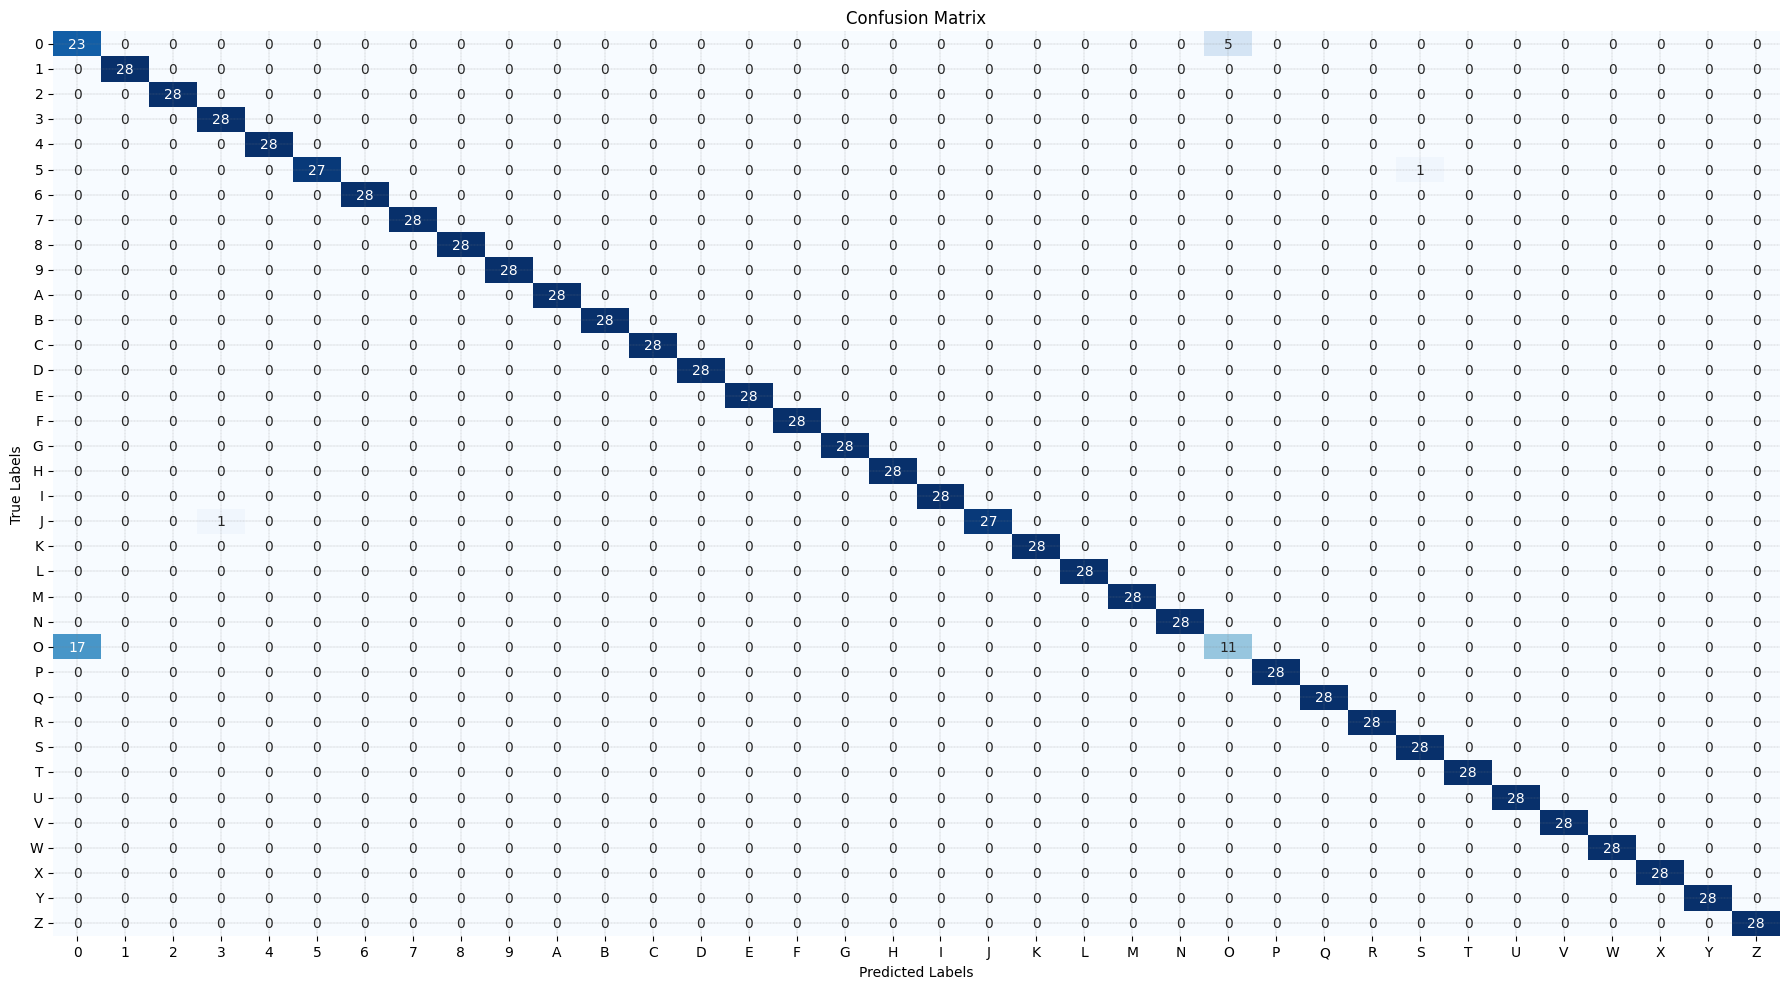

In [14]:
# Evaluation
test_predictions = np.array(predict(net, testloader, device, classes))
    
cm = confusion_matrix(labels_test, test_predictions)

# Plot confusion matrix
plt.figure(figsize=(18, 10))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False, xticklabels=classes, yticklabels=classes)
plt.grid(True, which='both', color='gray', linestyle='--', linewidth=0.2)
plt.gca().set_yticklabels(classes, rotation=0)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.show()